## It is a graduation project realized with CNN algorithms within the scope of bachelor's degree project.

- For this project, ı used 16,769 Chest X-ray images

In [ ]:
from google.colab import drive  #To get images from Drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib #we are using google colab GPU service
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11244068089050718882, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14509932544
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11926187888868330682
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
import os, glob, time, random

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()

from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as Layers
from tensorflow.keras.layers import Dropout

In [ ]:
datadir = '/content/drive/MyDrive/Colab/Covid-19-Xray/COVID'
seed = int(time.time())
imsize = (256, 256)

In [ ]:
augment = False

if augment:
    
    batch_size = 256
    
    traingGen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=3,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        rescale=1/255.,
        validation_split=0.2,
        dtype='float16'
    )
    
    testGen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1/255.,
        dtype='float16'
    ) 
    
    trainData = traingGen.flow_from_directory(
        directory = os.path.join(datadir, 'train'),
        color_mode="grayscale",
        batch_size=batch_size,
        target_size=imsize,
        shuffle=True,
        subset='training',
        seed = seed,
        class_mode="sparse"
    )
    
    valData = traingGen.flow_from_directory(
        directory = os.path.join(datadir, 'train'),
        color_mode="grayscale",
        batch_size=batch_size,
        target_size=imsize,
        shuffle=True,
        subset='validation',
        seed = seed,
        class_mode="sparse"
    )
    
    testData = testGen.flow_from_directory(
        directory = os.path.join(datadir, 'test'),
        color_mode="grayscale",
        batch_size=batch_size,
        target_size=imsize,
        class_mode="sparse",
        shuffle = False
    )
    
else:

    batch_size = 256
    
    trainData = tf.keras.preprocessing.image_dataset_from_directory(
        directory = os.path.join(datadir, 'train'),
        color_mode="grayscale",
        batch_size=batch_size,
        image_size=imsize,
        shuffle=True,
        validation_split=0.2,
        subset='training',
        seed = seed
    )

    valData = tf.keras.preprocessing.image_dataset_from_directory(
        directory = os.path.join(datadir, 'train'),
        color_mode="grayscale",
        batch_size=batch_size,
        image_size=imsize,
        shuffle=True,
        validation_split=0.2,
        subset='validation',
        seed = seed
    )

    testData = tf.keras.preprocessing.image_dataset_from_directory(
        directory = os.path.join(datadir, 'test'),
        color_mode="grayscale",
        batch_size=batch_size,
        image_size=imsize,
        shuffle = False
    )

Found 15077 files belonging to 3 classes.
Using 12062 files for training.
Found 15077 files belonging to 3 classes.
Using 3015 files for validation.
Found 1692 files belonging to 3 classes.


In [ ]:
def ClassCount(count):
    plt.figure(figsize=(12,8))
    plt.bar(range(len(count)), count.values())
    plt.xticks(range(len(count)),count.keys())
    plt.ylabel('Numbers')
    plt.xlabel('Classes')

In [ ]:
counts = {'train':{'COVID-19':1593,'normal':7966,'pneumonia':5462},
          'test': {'COVID-19':177, 'normal': 885,'pneumonia': 607}}
          
train_ratios = np.array(list(counts['train'].values()))/sum(counts['train'].values())

print('Class Rates:',train_ratios)

Sınıf oranları: [0.10605153 0.53032421 0.36362426]


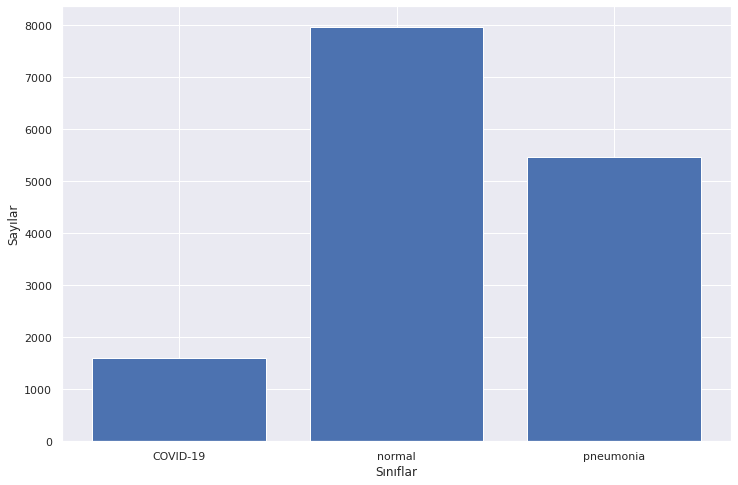

In [ ]:
ClassCount(counts['train'])

In [ ]:
def RandomImages(path):
    classNames = ['COVID-19','Normal','pneumonia']
    images = []
    for i, cn in enumerate(classNames):
        imageNames = imagesC19 = os.listdir(os.path.join(path,cn))
        filepath = random.choice(imageNames)
        images.append(Image.open(os.path.join(path,cn,filepath)))
    plt.figure(figsize=(18,6))
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary_r)
        plt.xlabel(classNames[i])
    plt.show()

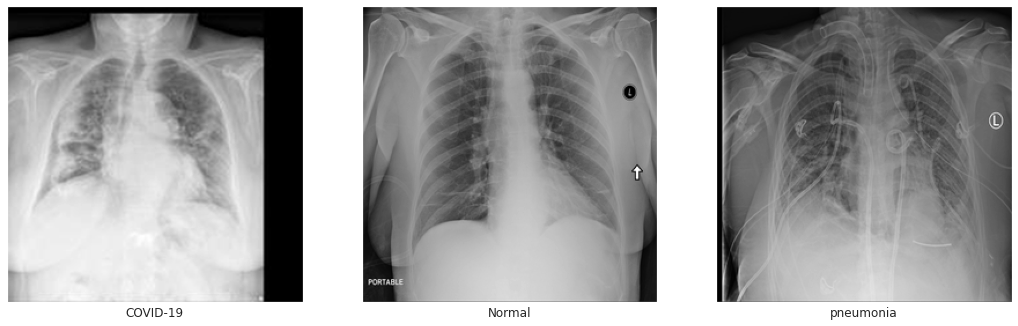

In [ ]:
RandomImages('/content/drive/MyDrive/Colab/Covid-19-Xray/COVID/train')

In [ ]:
def Net(optimizer='adam'):
  model = Sequential()

  model.add(Layers.Conv2D(16,(3,3),input_shape = (256,256,1), strides= 1, padding= 'same',name = 'Convolution-1'))
  model.add(Layers.Activation('relu'))
  model.add(Layers.MaxPool2D(pool_size=(2,2),strides=2,name = 'MaxPooling-1'))

  model.add(Layers.Conv2D(16,(3,3), strides= 1, padding= 'same',name = 'Convolution-2'))
  model.add(Layers.Activation('relu'))
  model.add(Layers.MaxPool2D(pool_size=(2,2),strides=2,name = 'MaxPooling-2'))
  model.add(Layers.BatchNormalization())

  model.add(Layers.Conv2D(32,(3,3), strides= 1, padding= 'same',name = 'Convolution-3'))
  model.add(Layers.Activation('relu'))
  model.add(Layers.MaxPool2D(pool_size=(2,2),strides=2,name = 'MaxPooling-3'))
  model.add(Layers.Flatten())  

  model.add(Layers.Dense(128, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Layers.Dense(64,activation='relu'))
  
  model.add(Layers.Dense(3,activation='softmax',name = 'Output'))
  model.compile(loss = 'sparse_categorical_crossentropy',optimizer = optimizer,metrics=['accuracy'])
  return model
  

In [ ]:

baseModel = Net(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))


earlyStop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)


modelSave = keras.callbacks.ModelCheckpoint('./checkpoint',monitor='val_accuracy', 
                                            save_best_only=True, save_weights_only=True,
                                            mode='max',)
epochs = 20

baseHist = baseModel.fit(trainData,
                         batch_size = batch_size,
                         epochs = epochs, verbose = 1,                       
                         validation_data=valData,
                         callbacks = [earlyStop, modelSave],                         
                         class_weight = {0: 4, 1: 1,2:1}
                        )

baseModel.summary()

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/20
48/48 [==============================] - 2097s 37s/step - loss: 1.0349 - accuracy: 0.6641 - val_loss: 1.3503 - val_accuracy: 0.5350
Epoch 2/20
48/48 [==============================] - 31s 574ms/step - loss: 0.7210 - accuracy: 0.7803 - val_loss: 0.7489 - val_accuracy: 0.6836
Epoch 3/20
48/48 [==============================] - 31s 563ms/step - loss: 0.6065 - accuracy: 0.8106 - val_loss: 0.5941 - val_accuracy: 0.7582
Epoch 4/20
48/48 [==============================] - 31s 562ms/step - loss: 0.5284 - accuracy: 0.8310 - val_loss: 0.5248 - val_accuracy: 0.8007
Epoch 5/20
48/48 [==============================] - 31s 568ms/step - loss: 0.4631 - accuracy: 0.8470 - val_loss: 0.4234 - val_accuracy: 0.8352
Epoch 6/20
48/48 [==============================] - 31s 565ms/step - loss: 0.4155 - accuracy: 0.8649 - val_loss: 0.4459 - val_accuracy: 0.8378
Epoc

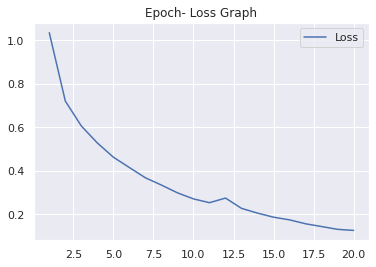

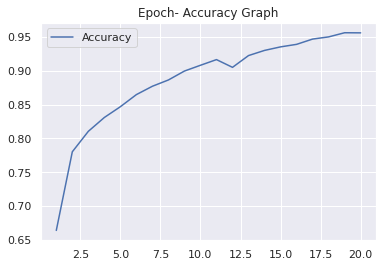

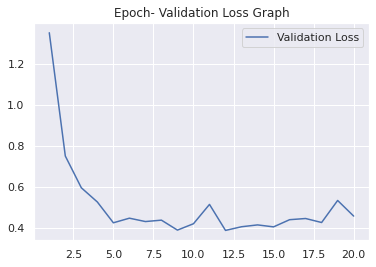

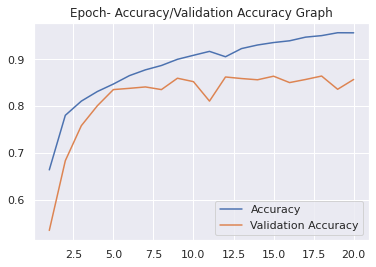

In [ ]:
plt.title('Epoch- Loss Graph')
plt.xlabel = 'Epoch'
plt.ylabel = 'Loss'
plt.plot(range(1,len(baseHist.epoch)+1), baseHist.history['loss'])
plt.legend(['Loss'])
plt.show()

plt.title('Epoch- Accuracy Graph')
plt.xlabel = 'Epoch'
plt.ylabel = 'Accuracy'
plt.plot(range(1,len(baseHist.epoch)+1), baseHist.history['accuracy'])
plt.legend(['Accuracy'])
plt.show()

plt.title('Epoch- Validation Loss Graph')
plt.xlabel = 'Epoch'
plt.ylabel = 'Validation Loss'
plt.plot(range(1,len(baseHist.epoch)+1), baseHist.history['val_loss'])
plt.legend(['Validation Loss'])
plt.show()

plt.title('Epoch- Accuracy/Validation Accuracy Graph')
plt.xlabel = 'Epoch'
plt.plot(range(1,len(baseHist.epoch)+1), baseHist.history['accuracy'])
plt.plot(range(1,len(baseHist.epoch)+1), baseHist.history['val_accuracy'])
plt.legend(['Accuracy','Validation Accuracy'])
plt.show()

In [ ]:

baseModel.load_weights('./checkpoint')
print('Train performance', baseModel.evaluate(trainData))


print('Test performance', baseModel.evaluate(testData))

48/48 [==============================] - 26s 462ms/step - loss: 0.1151 - accuracy: 0.9585
Eğitim performansı [0.11511930823326111, 0.9585475325584412]
7/7 [==============================] - 226s 32s/step - loss: 0.4326 - accuracy: 0.8576
Test performansı [0.4326488673686981, 0.8575649857521057]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
ypred = np.argmax(baseModel.predict(testData), axis=-1)
if augment:
    ytrue = testData.classes
else:
    ytrue = np.concatenate([y for x, y in testData], axis=0)
print(classification_report(ytrue, ypred))

              precision    recall  f1-score   support

           0       0.87      0.77      0.81       177
           1       0.86      0.91      0.89       885
           2       0.85      0.80      0.83       630

    accuracy                           0.86      1692
   macro avg       0.86      0.83      0.84      1692
weighted avg       0.86      0.86      0.86      1692



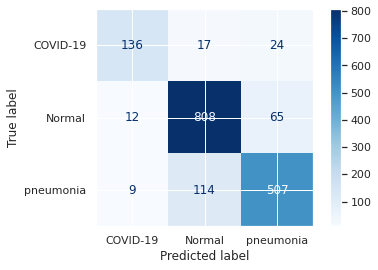

In [ ]:
cm = confusion_matrix(ytrue, ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['COVID-19','Normal','pneumonia'])
disp.plot(cmap='Blues',values_format='.4g')

In [ ]:
!nvidia-smi

Mon May 31 07:25:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    34W /  70W |   8030MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'restart': True, 'status': 'ok'}